<h1 style="text-align: center; color: darkblue;">Training Visualization</h1>

### 📑 <font color='blue'> Table of Contents </font>
1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Helper Functions](#helpers)
4. [Models](#models)
5. [Results analysis](#analysis)

<a name="introduction"></a>
## <font color="darkred"> 1. Introduction </font>

In this notebook, we focus on visualizing the training process of several candidate models for our project. The goal is not only to track performance metrics such as loss, recall, and F1 score across epochs, but also to compare training dynamics between models. By doing so, we can better understand which models converge faster, which ones are more stable, and which offer the best trade-off between recall, f1 (our most important metrics) and overall robustness.

This visualization-driven approach helps us:

- Identify overfitting or underfitting patterns.

- Compare models under the same conditions.

- Select the most promising candidate for further fine-tuning and deployment.

<a name="setup"></a>
## <font color="darkred"> 2. Setup </font>

In [17]:
from pathlib import Path
from collections import defaultdict
from datetime import datetime
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


<a name="helpers"></a>
## <font color="darkred"> 3. Helper Functions </font>

In [29]:
# loads data for a specific model-data_variant
def load_data(index_path):
    # Load runs_index.json
    with open(index_path) as f:
        runs_index = json.load(f)
    
    # Sort by timestamp
    runs_index.sort(key=lambda x: x["timestamp"])
    
    # Base directory for JSON files
    base_dir = index_path.parent
    
    # Collect runs (no need to group by model_name)
    runs = []
    for run in runs_index:
        run_path = base_dir / run["json_file"]
        with open(run_path) as f:
            run_data = json.load(f)
        runs.append(run_data)

    return runs


In [30]:
# get basic info
def get_data(data):
    # Separate sections
    basic_info_keys = ['model_name', 'data_variant', 'timestamp']
    basic_info = {k: data[k] for k in basic_info_keys}
    hyperparams = data['hyperparameters']
    val_metrics = data.get('val_metrics', {})  # use .get in case it's missing
    
    # Convert to DataFrames
    df_basic = pd.DataFrame([basic_info])
    df_basic["timestamp_readable"] = df_basic["timestamp"].apply(
        lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    )
    
    df_hyper = pd.DataFrame([hyperparams])
    df_val = pd.DataFrame([val_metrics]) if val_metrics else pd.DataFrame()

    #
    return df_basic, df_hyper, df_val


# display data
def display_data(df_basic, df_hyper, df_val):
    # Display nicely in notebook
    print("=== Basic Info ===")
    display(df_basic)
    
    print("=== Hyperparameters===")
    display(df_hyper.T)
    
    print("=== Validation Metrics===")
    display(df_val.T)


In [31]:
# plots
def plot_history(history):
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


In [32]:
# To visualize best models
def select_best_model(df, recall_threshold=0.9):
    """
    Select the best model + data variant combination for a medical problem.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: ['model_name', 'data_variant', 'recall', 'f1']
    recall_threshold : float
        Minimum acceptable recall
    
    Returns
    -------
    best_row : pd.Series
        Row corresponding to the combination with recall >= threshold and highest F1
    df_candidates : pd.DataFrame
        All combinations that meet the recall threshold, sorted by F1 descending
    """
    # Filter by recall threshold
    df_candidates = df[df['recall'] >= recall_threshold].copy()
    
    # Sort by F1 descending
    df_candidates.sort_values('f1', ascending=False, inplace=True)
    
    # Pick the best
    if not df_candidates.empty:
        best_row = df_candidates.iloc[0]
    else:
        best_row = None
    
    return best_row, df_candidates


# plot candidates
def plot_candidates(df, recall_threshold=0.9):
    """
    Plot all model + data variant combinations that meet a recall threshold,
    showing their F1 for easy comparison.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain ['model_name', 'data_variant', 'recall', 'f1']
    recall_threshold : float
        Minimum acceptable recall
    """
    # Filter candidates
    df_candidates = df[df['recall'] >= recall_threshold].copy()
    if df_candidates.empty:
        print("No combinations meet the recall threshold.")
        return
    
    # Create a combo label
    df_candidates['combo'] = df_candidates['model_name'] + ' + ' + df_candidates['data_variant']
    
    # Bar plot of F1
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_candidates, x='combo', y='f1', palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('F1-score')
    plt.title(f'F1 for Combinations with Recall ≥ {recall_threshold}')
    plt.tight_layout()
    plt.show()



<a name="models"></a>
## <font color="darkred"> 4. Models </font>

In [33]:
# all_results: start empty
all_results = pd.DataFrame()

### <font color="darkorange"> 4.1. Baseline </font>

#### Simple data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,simple,20250909_155737,2025-09-09 15:57:37


=== Hyperparameters===


,0
batch_size,64
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,1.248314
accuracy,0.754386
precision,0.666667
recall,0.666667
f1,0.666667


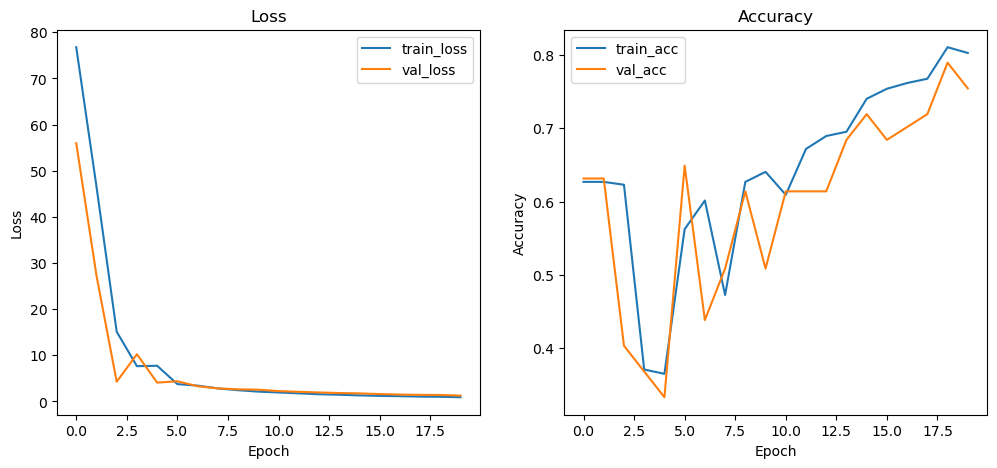

In [34]:
index_path = Path("../logs/training/baseline/simple/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)
        


#### Standardize data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,standardize,20250909_155742,2025-09-09 15:57:42


=== Hyperparameters===


,0
batch_size,64
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,0.256503
accuracy,0.912281
precision,0.833333
recall,0.952381
f1,0.888889


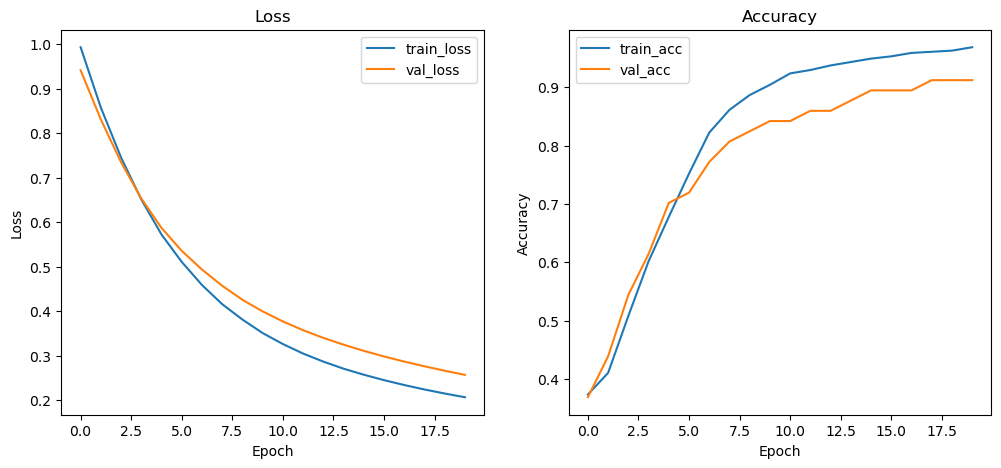

In [35]:
index_path = Path("../logs/training/baseline/standardize/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)


### <font color="darkorange"> 4.2. No dropout </font>

#### Simple data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,no_dropout,simple,20250909_155738,2025-09-09 15:57:38


=== Hyperparameters===


,0
batch_size,64
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,0.482699
accuracy,0.894737
precision,0.941176
recall,0.761905
f1,0.842105


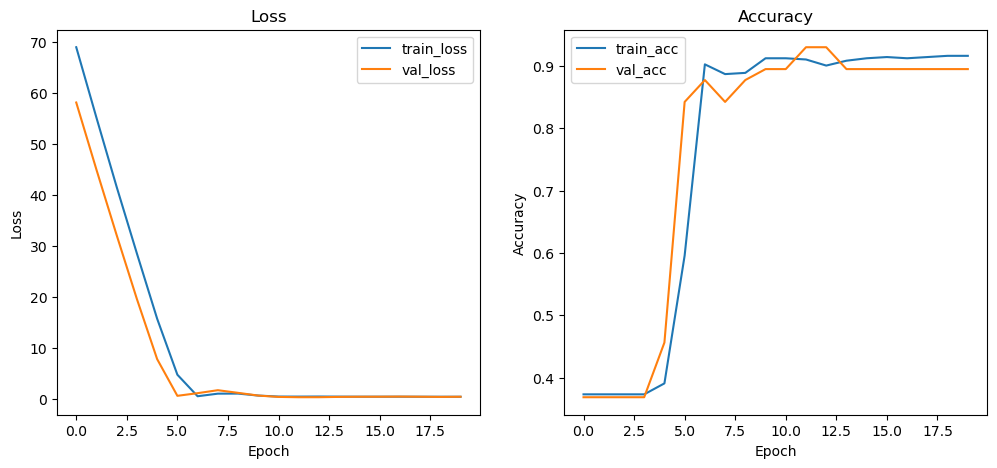

In [36]:
index_path = Path("../logs/training/no_dropout/simple/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)



#### Standardize data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,no_dropout,standardize,20250909_155744,2025-09-09 15:57:44


=== Hyperparameters===


,0
batch_size,64
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,0.088386
accuracy,1.000000
precision,1.000000
recall,1.000000
f1,1.000000


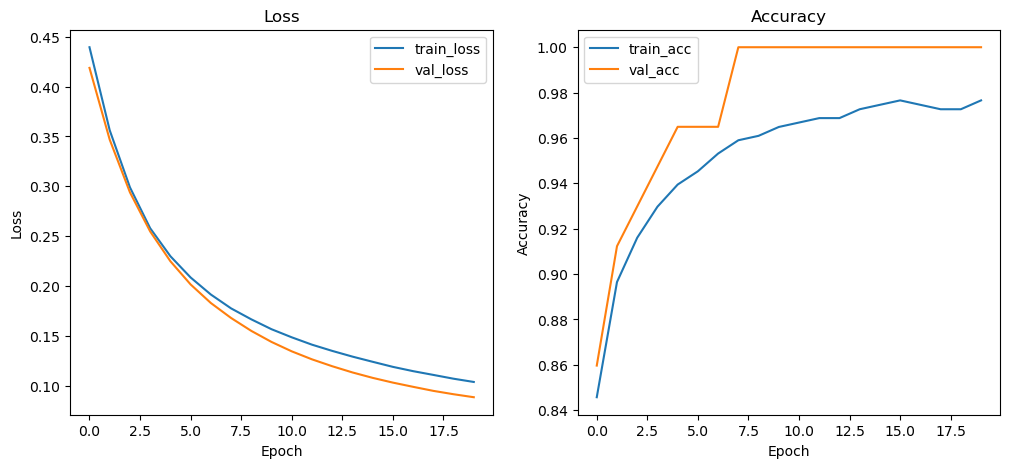

In [37]:
index_path = Path("../logs/training/no_dropout/standardize/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)


### <font color="darkorange"> 4.3. Dropout </font>

#### Simple data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,dropout,simple,20250909_155740,2025-09-09 15:57:40


=== Hyperparameters===


,0
batch_size,64
dropout_rate,0.1
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,0.369259
accuracy,0.842105
precision,0.714286
recall,0.952381
f1,0.816327


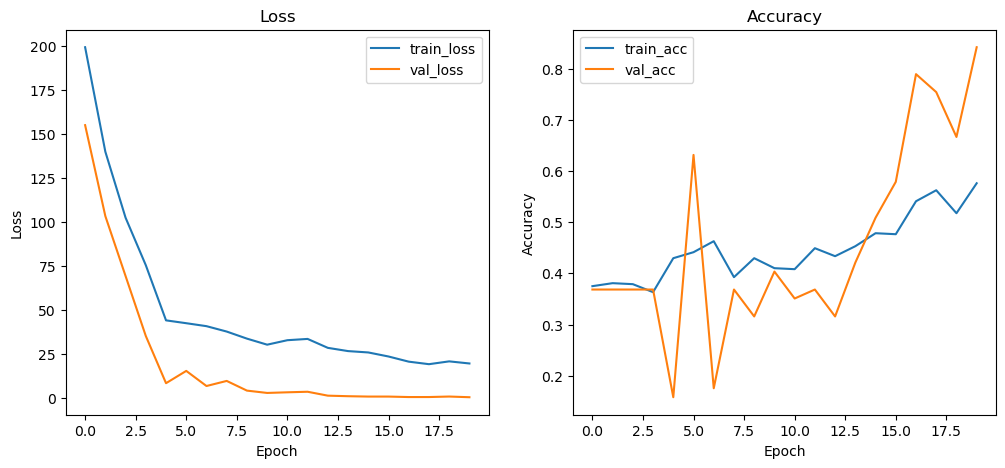

In [38]:
index_path = Path("../logs/training/dropout/simple/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)


#### Standardize data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,dropout,standardize,20250909_155745,2025-09-09 15:57:45


=== Hyperparameters===


,0
batch_size,64
dropout_rate,0.1
optimizer,adam
learning_rate,0.001
epochs,20


=== Validation Metrics===


,0
loss,0.065605
accuracy,1.000000
precision,1.000000
recall,1.000000
f1,1.000000


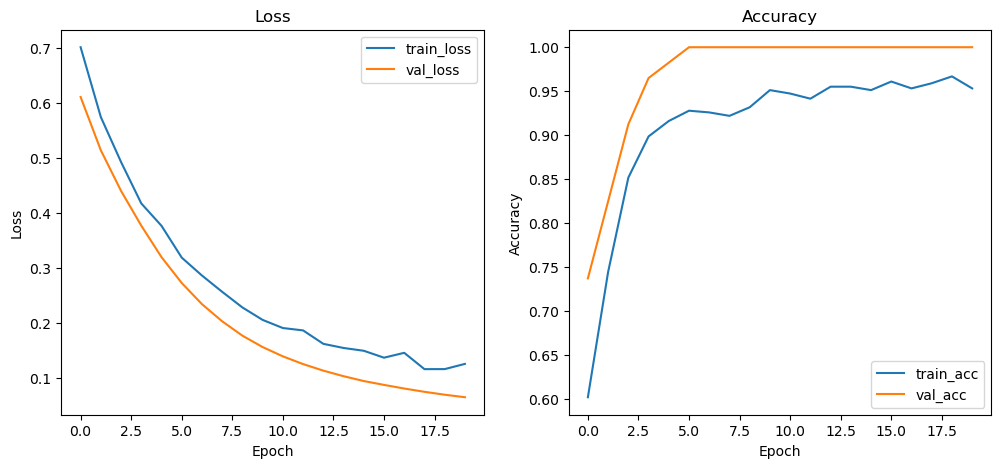

In [39]:
index_path = Path("../logs/training/dropout/standardize/runs_index.json")

models = load_data(index_path)
    
for m in models:
    # get data
    basic, hyperparams, val_metrics = get_data(m)
    display_data(basic, hyperparams, val_metrics)
    # combine into one row
    df_result = pd.concat([basic, val_metrics], axis=1)
    # add to results
    all_results = pd.concat([all_results, df_result], ignore_index=True)
    # plot
    history = m['history']
    plot_history(history)


<a name="analysis"></a>
## <font color="darkred"> 5. Results analysis </font>

In [40]:
all_results

,model_name,data_variant,timestamp,timestamp_readable,loss,accuracy,precision,recall,f1
0,baseline,simple,20250909_155737,2025-09-09 15:57:37,1.248314,0.754386,0.666667,0.666667,0.666667
1,baseline,standardize,20250909_155742,2025-09-09 15:57:42,0.256503,0.912281,0.833333,0.952381,0.888889
2,no_dropout,simple,20250909_155738,2025-09-09 15:57:38,0.482699,0.894737,0.941176,0.761905,0.842105
3,no_dropout,standardize,20250909_155744,2025-09-09 15:57:44,0.088386,1.000000,1.000000,1.000000,1.000000
4,dropout,simple,20250909_155740,2025-09-09 15:57:40,0.369259,0.842105,0.714286,0.952381,0.816327
5,dropout,standardize,20250909_155745,2025-09-09 15:57:45,0.065605,1.000000,1.000000,1.000000,1.000000


In [41]:
best, candidates = select_best_model(all_results, recall_threshold=0.9)

print("Best combination:")
print(best[['model_name','data_variant','recall','f1']])

print("\nAll candidates meeting recall threshold:")
print(candidates[['model_name','data_variant','recall','f1']])


Best combination:
model_name       no_dropout
data_variant    standardize
recall                  1.0
f1                      1.0
Name: 3, dtype: object

All candidates meeting recall threshold:
   model_name data_variant    recall        f1
3  no_dropout  standardize  1.000000  1.000000
5     dropout  standardize  1.000000  1.000000
1    baseline  standardize  0.952381  0.888889
4     dropout       simple  0.952381  0.816327


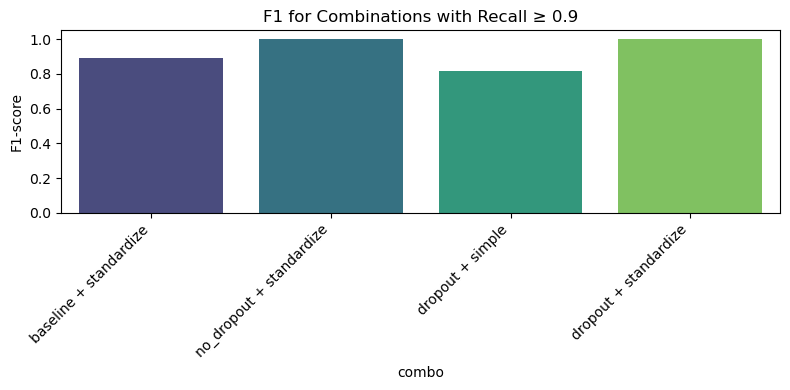

In [42]:
plot_candidates(all_results, recall_threshold=0.9)

**Key takeaways**

- We always obatin much better results and a more stable training with standardize data.

- We reach very good results even training our models for a very few epochs; but thats because our probelm is very simple.